# Lab2. Custom CNN script with Tensorflow and Keras

In this lab, you will develop your own Tensorflow-based Keras CNN script to recognize characters from cropped license plate.  

## Set up your local environment

* **Please note that the Tensorflow eager mode will be enabled by below code:**  
 tf.enable_eager_execution()

In [1]:
import numpy as np
from keras import layers

import os
import argparse

import json
from PIL import Image
import tensorflow as tf

#from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()

print(tf.VERSION)
import sys
print(sys.version)  

Using TensorFlow backend.



1.15.5
3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]


* Load the number character definition list 

In [2]:
from common import JOIN
n_chr = len(JOIN)

## Divide train and validation data from cropped images

* We will use cropped-imgs and nums-tags which we generated at Lab0

In [3]:
jsons = os.listdir('gen/nums-tags')
print ('There are {:,} images have annotation files.'.format(len(jsons)))
print ('There are {:,} image files.'.format(len(os.listdir('gen/cropped-imgs'))))

There are 10,000 images have annotation files.
There are 10,000 image files.


* prepare folder to store divided train/validation data

In [4]:
!rm -fR tf
!mkdir tf tf/tf-train tf/tf-train_annotation tf/tf-validation tf/tf-validation_annotation

* Define the number of train/valdiation images

In [5]:
n_samples = len(os.listdir('gen/cropped-imgs'))
n_val = 5000 if n_samples > 25000 else round(n_samples * 0.2)
n_train = n_samples - n_val
print('{:,} images will be used for training, and {:,} images will be used for validation.'.format(n_train, n_val))

8,000 images will be used for training, and 2,000 images will be used for validation.


* Copy images and annotation files to tf-train and tf-validation folders  

In [6]:
import shutil

train_jsons = jsons[:n_train]
val_jsons = jsons[n_train:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './gen/cropped-imgs/'+i.split('.')[0]+'.png'
    shutil.copy(image_file, './tf/tf-train/')
    shutil.copy('./gen/nums-tags/'+i, './tf/tf-train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './gen/cropped-imgs/'+i.split('.')[0]+'.png'
    shutil.copy(image_file, './tf/tf-validation/')
    shutil.copy('./gen/nums-tags/'+i, './tf/tf-validation_annotation/')

* check the move result

In [7]:
print('there are {:,} files in gen/cropped-imgs folder.'.format(len(os.listdir('gen/cropped-imgs'))))
print('there are {:,} files in gen/nums-tags folder.'.format(len(os.listdir('gen/nums-tags'))))
print('there are {:,} files in tf/tf-train folder.'.format(len(os.listdir('tf/tf-train'))))
print('there are {:,} files in tf/tf-train_annotation folder.'.format(len(os.listdir('tf/tf-train_annotation'))))
print('there are {:,} files in tf/tf-validation folder.'.format(len(os.listdir('tf/tf-validation'))))
print('there are {:,} files in tf/tf-validation_annotation folder.'.format(len(os.listdir('tf/tf-validation_annotation'))))

there are 10,000 files in gen/cropped-imgs folder.
there are 10,000 files in gen/nums-tags folder.
there are 8,000 files in tf/tf-train folder.
there are 8,000 files in tf/tf-train_annotation folder.
there are 2,000 files in tf/tf-validation folder.
there are 2,000 files in tf/tf-validation_annotation folder.


## Load data(images/annotations) for local training

* Define a function to read the pair of cropped image and annotation
* Image will be resized to IMAGE_WIDTH x IMAGE_HEIGHT
* Annotation t_annotations and v_annotations are lists of 7 np array representing digit of each 7 positions

In [8]:
from common import get_data_pair

In [9]:
t_imgs, t_annotations = get_data_pair('tf/tf-train', 'tf/tf-train_annotation')
v_imgs, v_annotations = get_data_pair('tf/tf-validation', 'tf/tf-validation_annotation')

In [10]:
print('{:,} train images and {:,} annotations were loaded.'.format(len(t_imgs),len(t_annotations[0])))
print('{:,} validation images and {:,} annotations were loaded.'.format(len(v_imgs),len(v_annotations[0])))

8,000 train images and 8,000 annotations were loaded.
2,000 validation images and 2,000 annotations were loaded.


In [11]:
print(len(t_imgs)) # 8,000 examples
print(t_imgs[0].shape)
print(len(t_annotations)) # list of 7 digits
print(t_annotations[0].shape) # each annotation ndarray has the calss of n_chr characters
print(t_annotations[1].shape) 
print(t_annotations[6].shape) 


8000
(128, 64, 1)
7
(8000, 37)
(8000, 37)
(8000, 37)


* Check 3 sample pairs of training inage and annotation

In [12]:
import matplotlib.pyplot as plt
from common import model, IMAGE_WIDTH, IMAGE_HEIGHT

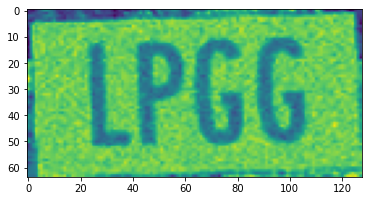

['L', 'P', 'G', 'G', ' ', ' ', ' ']


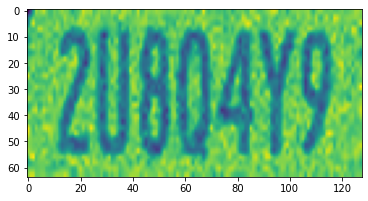

['2', 'U', '8', 'Q', '4', 'Y', '9']


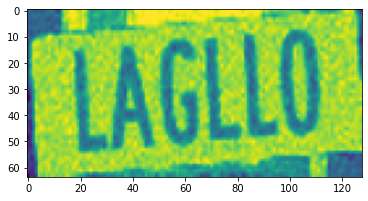

['L', 'A', 'G', 'L', 'L', 'O', ' ']


In [13]:
for i in range(3):
    plt.imshow(t_imgs[i].reshape([IMAGE_HEIGHT,IMAGE_WIDTH]))
    plt.show()
    digits = [JOIN[np.argmax(t_annotations[0][i])], 
              JOIN[np.argmax(t_annotations[1][i])], 
              JOIN[np.argmax(t_annotations[2][i])], 
              JOIN[np.argmax(t_annotations[3][i])], 
              JOIN[np.argmax(t_annotations[4][i])], 
              JOIN[np.argmax(t_annotations[5][i])], 
              JOIN[np.argmax(t_annotations[6][i])]]
    print(digits)

## Define CNN model
* Define 3 Convolutions layers with Batch Normalization and Max Pooling with Keras
* Will have 7 output nodes representing license plate character at each position

In [14]:
from common import model, IMAGE_WIDTH, IMAGE_HEIGHT

* Compile the model and veiw summary

In [15]:
input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,1)
model_k = model(input_shape)
model_k.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                      'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
                metrics = ["accuracy"])
model_k.summary()

Model: "CNN_ANPR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 132, 68, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 64, 48)  1248        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 128, 64, 48)  192         conv0[0][0]                      
___________________________________________________________________________________________

* Finally, run traing job
* **It may take 1~2 minutes**
* For now, We wll just run 1 epochs to see if our code works well
* **Do check the loss is decresing and the accuracy is increasing from training job logs**

In [16]:
%%time
model_k.fit(t_imgs, [i.reshape([-1,n_chr]) for i in t_annotations], 
            validation_data=(v_imgs, [i.reshape([-1,n_chr]) for i in v_annotations]), 
            epochs=1, batch_size=128, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8000 samples, validate on 2000 samples
8000/8000 [==============================] - 208s 26ms/sample - loss: 19.2942 - d1_loss: 3.8514 - d2_loss: 3.9099 - d3_loss: 3.7561 - d4_loss: 3.0461 - d5_loss: 2.3051 - d6_loss: 1.6077 - d7_loss: 0.7959 - d1_acc: 0.0461 - d2_acc: 0.0362 - d3_acc: 0.1042 - d4_acc: 0.3075 - d5_acc: 0.5045 - d6_acc: 0.6971 - d7_acc: 0.8857 - val_loss: 26.7965 - val_d1_loss: 4.1307 - val_d2_loss: 4.1108 - val_d3_loss: 4.7888 - val_d4_loss: 4.7810 - val_d5_loss: 4.1849 - val_d6_loss: 3.3881 - val_d7_loss: 1.4036 - val_d1_acc: 0.0195 - val_d2_acc: 0.0230 - val_d3_acc: 0.1035 - val_d4_acc: 0.2950 - val_d5_acc: 0.4990 - val_d6_acc: 0.6890 - val_d7_acc: 0.8900
CPU times: user 4min 39s, sys: 58 s, total: 5min 37s
Wall time: 3min 30s


## Evaluate model (It is not accurate yet)

* Check the overall accuracy

In [17]:
preds = model_k.evaluate(v_imgs, [i.reshape([-1,n_chr]) for i in v_annotations], batch_size=64, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2000/2000 [==============================] - 27s 14ms/sample - loss: 26.7965 - d1_loss: 4.1263 - d2_loss: 4.1104 - d3_loss: 4.7927 - d4_loss: 4.7724 - d5_loss: 4.1966 - d6_loss: 3.3693 - d7_loss: 1.3971 - d1_acc: 0.0195 - d2_acc: 0.0230 - d3_acc: 0.1035 - d4_acc: 0.2950 - d5_acc: 0.4990 - d6_acc: 0.6890 - d7_acc: 0.8900

Loss = 26.796496490478514
Test Accuracy = 4.1262627


* Check the prediction results of 3 sample data pairs

In [18]:
prediction = model_k.predict(v_imgs[:10])

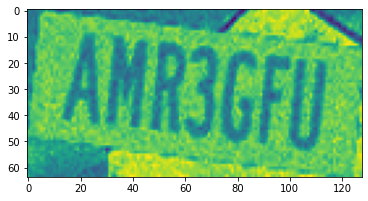

['O', '3', ' ', ' ', ' ', ' ', ' ']


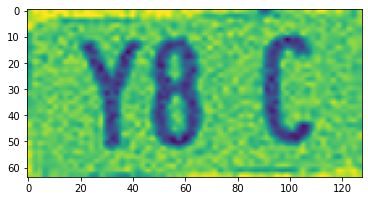

['O', '3', ' ', ' ', ' ', ' ', ' ']


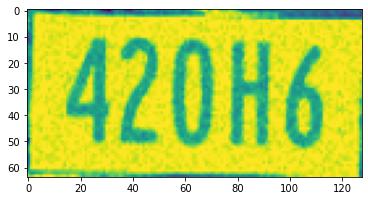

['O', '3', ' ', ' ', ' ', ' ', ' ']


In [19]:
for i in range(3):
    plt.imshow(v_imgs[i].reshape([IMAGE_HEIGHT,IMAGE_WIDTH]))
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][i])], 
              JOIN[np.argmax(prediction[1][i])], 
              JOIN[np.argmax(prediction[2][i])], 
              JOIN[np.argmax(prediction[3][i])], 
              JOIN[np.argmax(prediction[4][i])], 
              JOIN[np.argmax(prediction[5][i])], 
              JOIN[np.argmax(prediction[6][i])]]
    print(digits)

* We verified our code runs successfully
* The accuracy of our model is not good enough yet
* **We will retrain our model with SageMaker in Lab3**

## Next step
Remember you defined model() and get_data_pair() function.  
Move to [Lab3](Lab3-train-deploy-host-on-SM.ipynb) to run this code on the Cloud.